In [ ]:
!nvidia-smi

Fri Dec 17 10:43:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Dowloading and becoming one with data

In [ ]:
import zipfile

# dowload the data 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# unzip the dowloaded folder
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2021-12-17 10:43:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.120.128, 142.250.128.128, 142.251.6.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.120.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   100MB/s    in 1.6s    

2021-12-17 10:43:27 (100 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



now that we have zip file downloaded and we have extracted all the folders from the zip file. 

it is time to explore the data directory and see how it is organise.

This can be done in two steps
1. we need to ger dependencies first (ofcourse we should) So download `os` library.
2. use random walk function of the os library to walk through the directory and print the folder names and no of the file in each folder.

In [ ]:
# how many images in each folder?
import os

# walk through the 10_food_classes_10_percent data directory and list the number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f'There are {len(dirnames):>5} folders and {len(filenames):>5} images in {dirpath}')

There are     2 folders and     0 images in 10_food_classes_10_percent
There are    10 folders and     0 images in 10_food_classes_10_percent/test
There are     0 folders and   250 images in 10_food_classes_10_percent/test/fried_rice
There are     0 folders and   250 images in 10_food_classes_10_percent/test/grilled_salmon
There are     0 folders and   250 images in 10_food_classes_10_percent/test/steak
There are     0 folders and   250 images in 10_food_classes_10_percent/test/hamburger
There are     0 folders and   250 images in 10_food_classes_10_percent/test/chicken_curry
There are     0 folders and   250 images in 10_food_classes_10_percent/test/pizza
There are     0 folders and   250 images in 10_food_classes_10_percent/test/sushi
There are     0 folders and   250 images in 10_food_classes_10_percent/test/ramen
There are     0 folders and   250 images in 10_food_classes_10_percent/test/chicken_wings
There are     0 folders and   250 images in 10_food_classes_10_percent/test/ice_c

# Creating data loader and preparing the data

In [ ]:
# Setup Data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

# define diretory path to be used in ImageDataGenerator
train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

# Create a data generator object
train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

# prepare the data using flow_from_directory method
print("Train Images") 
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size = IMAGE_SHAPE,
                                               batch_size = BATCH_SIZE,
                                               class_mode = 'categorical')

print('Test Images')
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMAGE_SHAPE,
                                             batch_size = BATCH_SIZE,
                                             class_mode = 'categorical')



Train Images
Found 750 images belonging to 10 classes.
Test Images
Found 2500 images belonging to 10 classes.


In [ ]:
train_data_10_percent

# Setting up the callbaks

Callbacks are the extra functinality you can add to your models to be performed during training. they act more like logfile for each epoch

> Tracking experiments with TensorBoard Callback
> Model check point call back for traking the model weights after each epoch
> early stopping call back to stop training if the desired metrics are not improving

In [ ]:
# Create tensorboard callback (functionized because we need to create one for every model we build)
import datetime

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime("%y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f'saving tensorboard log files to "{log_dir}".')
  return tensorboard_callback

# Creating models using Tensorflow Hub

In [ ]:
# Let's compare following models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# import dependencies

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
type(IMAGE_SHAPE)

tuple

In [ ]:
IMAGE_SHAPE + (3,)

(224, 224, 3)

In [ ]:
# Let's make a create_model() function to create a model from url

def create_model(model_url, num_classes=10):
  """
  Takes a pretrained model url and creates a keras Sequential model instance with it.
  
  Args:
  - model_url(str) : A tensorflow_hub feature extraction URL
  - num_classes (int): Number of output neurons in the output layers
    should be same as number of classes to be classified. default = 10
  
  Returns:
  A compiled Sequential model with model_url as feature extraction layer 
  and a Dense output layer with num_classes output neurons 
  """
  # dowload the pretrained model and save it as a keras layer

  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False,
                                           input_shape = IMAGE_SHAPE + (3,),
                                           name = 'feature_extraction_layer')
  # feature_extractor_layer.build([None,224,224,3])
  
  # Create a model
  model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes,
                     activation = 'softmax',
                     name = 'output_layer')
  ])
  model.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy']) 

  return model

In [ ]:
# create a resnet model
resnet_model = create_model(resnet_url,num_classes = 10)

In [ ]:
# resnet_model.compile(loss = 'categorical_crossentropy',
#                      optimizer = tf.keras.optimizers.Adam(),
#                      metrics = ['accuracy'])

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
resnet_history = resnet_model.fit(train_data_10_percent,
                              epochs = 5,
                              steps_per_epoch = len(train_data_10_percent),
                              validation_data = test_data,
                              validation_steps = len(test_data),
                              callbacks = [create_tensorboard_callback(dir_name = 'trf_learning_experiments',
                                                                       experiment_name = 'resnet50V2_experiment'
                                                                       )])

saving tensorboard log files to "trf_learning_experiments/resnet50V2_experiment/211217-104502".
Epoch 1/5
24/24 [==============================] - 41s 1s/step - loss: 1.9466 - accuracy: 0.3520 - val_loss: 1.2305 - val_accuracy: 0.6240
Epoch 2/5
24/24 [==============================] - 26s 1s/step - loss: 0.8982 - accuracy: 0.7453 - val_loss: 0.8437 - val_accuracy: 0.7412
Epoch 3/5
24/24 [==============================] - 23s 988ms/step - loss: 0.6247 - accuracy: 0.8200 - val_loss: 0.7405 - val_accuracy: 0.7676
Epoch 4/5
24/24 [==============================] - 22s 930ms/step - loss: 0.4792 - accuracy: 0.8693 - val_loss: 0.7039 - val_accuracy: 0.7692
Epoch 5/5
24/24 [==============================] - 22s 931ms/step - loss: 0.3822 - accuracy: 0.9160 - val_loss: 0.6781 - val_accuracy: 0.7844


In [ ]:
# let's create a function to plot our loss curves...
## we can always put into a script file for furture use. all we need to do is to import these functions into our working environment.
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics / loss

  Args:
  - history: Tensorflow history object

  Retruns:
  - Plots for Loss and accuracy for training and validation separately
  """

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  #plot curves
  plt.figure(figsize = (20,7))
  # plt.subplots(1,2,1)
  plt.plot(epochs,loss,label = 'Training loss')
  plt.plot(epochs,val_loss, label = 'Validation loss')
  plt.title('Training vs Validation loss curves')
  plt.legend()
  plt.xlabel('epochs')

  plt.figure(figsize = (20,7))
  # plt.subplots(1,2,2)
  plt.plot(epochs, accuracy, label = 'Training accuracy')
  plt.plot(epochs, val_accuracy, label = 'Validation accuracy')
  plt.title('Training vs Validation Accuracy curves')
  plt.xlabel('epochs')
  plt.legend()


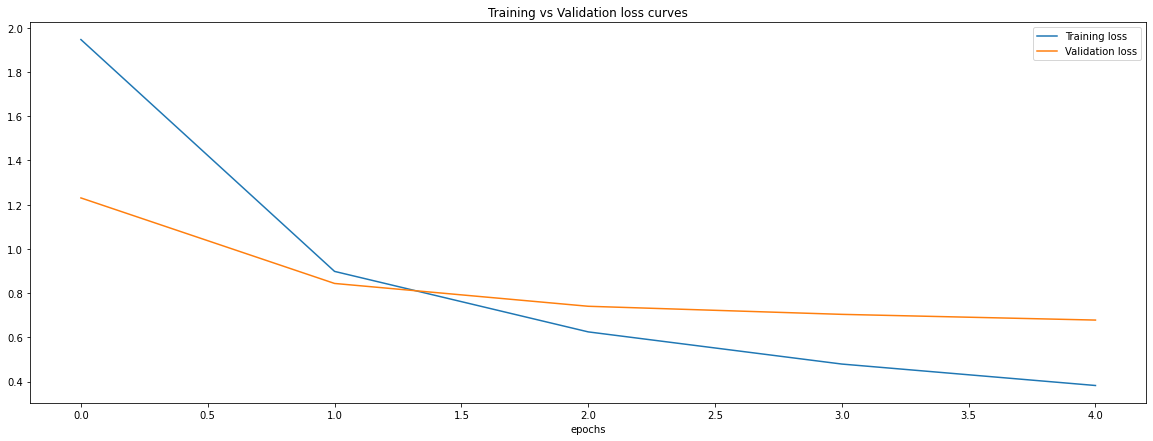

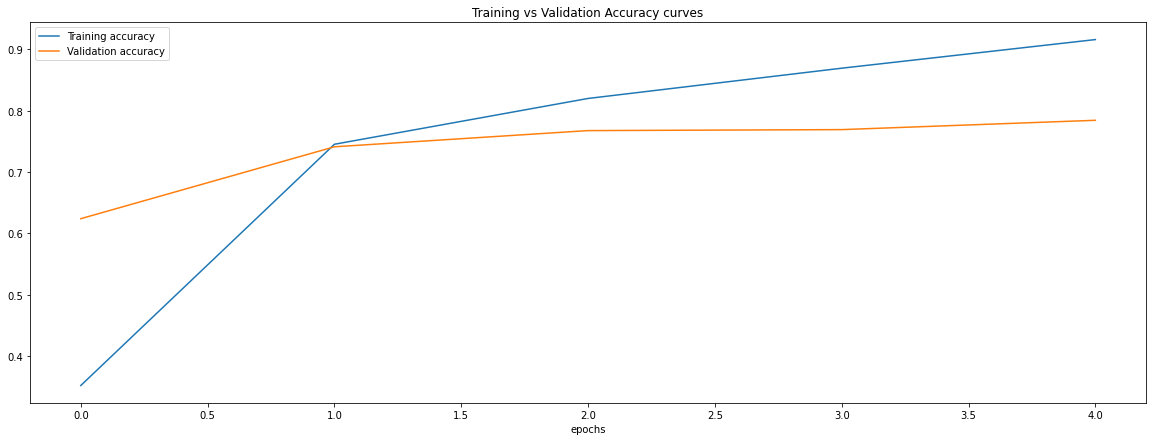

In [ ]:
plot_loss_curves(resnet_history)

# Creating Efficientnet model

In [ ]:
# Create Efficientnet feature extractor model - details on https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html#:~:text=EfficientNet%2DB0%20is%20the%20baseline,than%20the%20best%20existing%20CNN.
efficientnet_model = create_model('https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2',
                                  num_classes = 10)


# Compile efficientnet model

efficientnet_model.compile(loss = 'categorical_crossentropy',
                           optimizer = tf.keras.optimizers.Adam(),
                           metrics = ['accuracy'])

# Fit model to 10% dataset

efficient_history = efficientnet_model.fit(train_data_10_percent,
                                           epochs = 5,
                                           steps_per_epoch = len(train_data_10_percent),
                                           validation_data = test_data,
                                           validation_steps = len(test_data),
                                           callbacks = [create_tensorboard_callback(dir_name = 'tensorflow_hub',
                                                                                    experiment_name = 'efficientnet_10_percent')])

saving tensorboard log files to "tensorflow_hub/efficientnet_10_percent/211217-105201".
Epoch 1/5
24/24 [==============================] - 34s 1s/step - loss: 1.9550 - accuracy: 0.3440 - val_loss: 1.5190 - val_accuracy: 0.5984
Epoch 2/5
24/24 [==============================] - 19s 803ms/step - loss: 1.3162 - accuracy: 0.6840 - val_loss: 1.1347 - val_accuracy: 0.7024
Epoch 3/5
24/24 [==============================] - 19s 795ms/step - loss: 1.0144 - accuracy: 0.7440 - val_loss: 0.9648 - val_accuracy: 0.7372
Epoch 4/5
24/24 [==============================] - 19s 805ms/step - loss: 0.8509 - accuracy: 0.8027 - val_loss: 0.8653 - val_accuracy: 0.7548
Epoch 5/5
24/24 [==============================] - 19s 802ms/step - loss: 0.7426 - accuracy: 0.8147 - val_loss: 0.8058 - val_accuracy: 0.7640


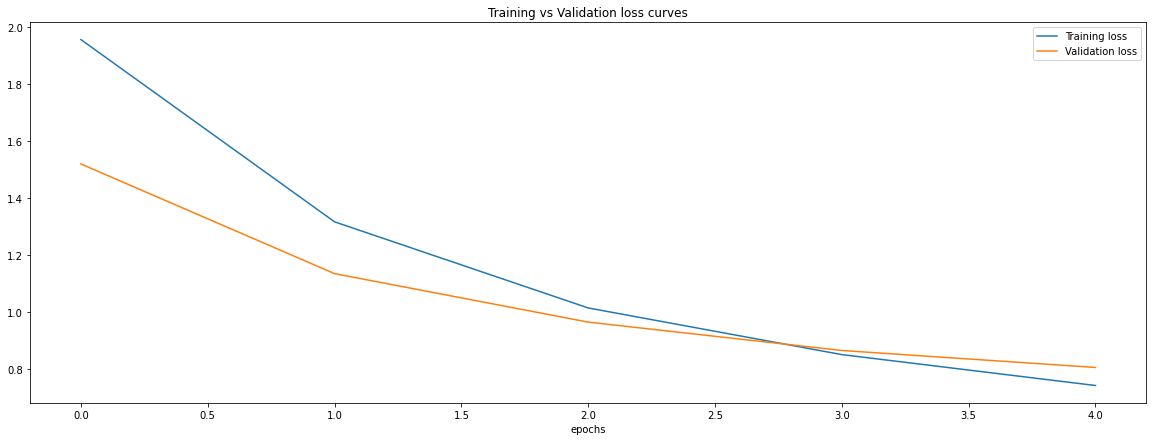

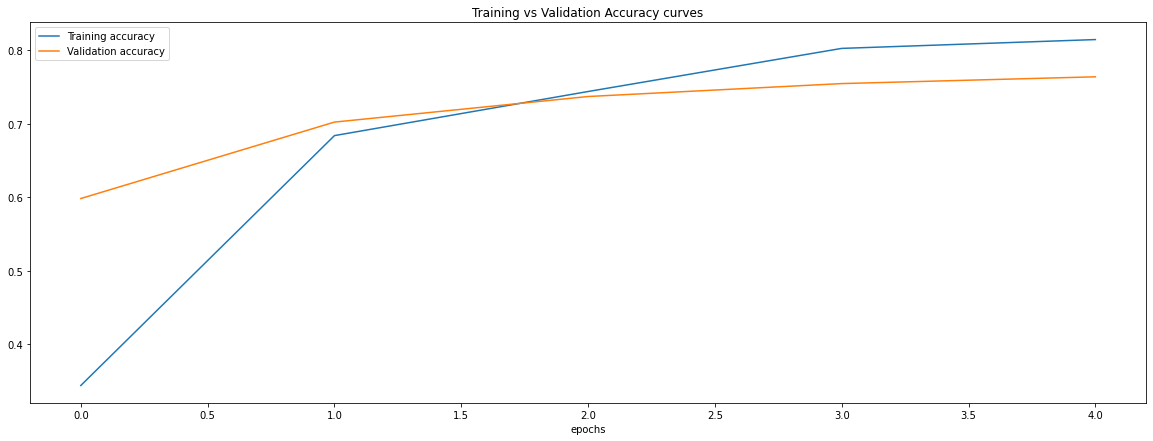

In [ ]:
plot_loss_curves(efficient_history)

# efficientnet B0 old version

In [ ]:
efficientnet_model = create_model(efficientnet_url, num_classes=10)

In [ ]:
efficientnet_model.compile(loss = 'categorical_crossentropy',
                           optimizer = tf.keras.optimizers.Adam(),
                           metrics = ['accuracy'])

In [ ]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
efficientnet_model.fit(train_data_10_percent,
                       epochs = 5)

Epoch 1/5
24/24 [==============================] - 16s 225ms/step - loss: 1.8679 - accuracy: 0.4120
Epoch 2/5
24/24 [==============================] - 5s 191ms/step - loss: 1.0809 - accuracy: 0.7693
Epoch 3/5
24/24 [==============================] - 5s 191ms/step - loss: 0.7599 - accuracy: 0.8373
Epoch 4/5
24/24 [==============================] - 5s 191ms/step - loss: 0.6063 - accuracy: 0.8653
Epoch 5/5
24/24 [==============================] - 5s 190ms/step - loss: 0.5134 - accuracy: 0.8853


In [ ]:
efficientnet_model.evaluate(test_data)

79/79 [==============================] - 17s 198ms/step - loss: 0.5635 - accuracy: 0.8572


[0.5634743571281433, 0.857200026512146]

### Can not plot loss curves as we have not created a history object for our last model.

# Other experiments

In [ ]:
inputs = layers.Input(shape = (224,224,3))
x = layers.GlobalAveragePooling2D()(inputs)
x = layers.Dense(10, activation = 'relu')(x)
outputs = layers.Dense(10, activation = 'softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

model.fit(train_data_10_percent,
          epochs = 2)

Epoch 1/2
24/24 [==============================] - 4s 150ms/step - loss: 2.3167 - accuracy: 0.1000
Epoch 2/2
24/24 [==============================] - 4s 150ms/step - loss: 2.3118 - accuracy: 0.1000


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 global_average_pooling2d (G  (None, 3)                0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                40        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
Total params: 150
Trainable params: 150
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = tf.keras.Sequential([
    layers.Input(shape=(224,224,3)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(10, activation = 'softmax')
])

model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_1   (None, 3)                0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 10)                40        
                                                                 
Total params: 40
Trainable params: 40
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(train_data_10_percent,
          epochs = 2)

Epoch 1/2
24/24 [==============================] - 4s 151ms/step - loss: 2.3415 - accuracy: 0.0987
Epoch 2/2
24/24 [==============================] - 4s 151ms/step - loss: 2.3352 - accuracy: 0.0987


In [ ]:
feature_extractor = hub.KerasLayer(resnet_url, trainable = False)
feature_extractor.build([None,224,224,3])
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(10, activation = 'softmax')
])

# model.build([224,224,3])

model.compile(loss = 'categorical_crossentropy',
              metrics = ['accuracy'],
              optimizer = tf.keras.optimizers.Adam())


In [ ]:
model.fit(train_data_10_percent,
          epochs = 2)

Epoch 1/2
24/24 [==============================] - 10s 213ms/step - loss: 1.9020 - accuracy: 0.3773
Epoch 2/2
24/24 [==============================] - 5s 212ms/step - loss: 0.9137 - accuracy: 0.7200
